### AstroPy-based .fits Reader

This notebook includes an example of how to read the .fits files located in same directory as this notebook. These files contain neutrino luminosity, mean energy, and energy spectrum pinch parameter (alpha) as functions of time for the CCSN neutrino flavors. These were obtained using models from Nakazato et al., 2013 and 2015. Data are public and taken from their [website](http://asphwww.ph.noda.tus.ac.jp/snn/).

The citation for use of the database is: Supernova Neutrino Light Curves and Spectra for Various Progenitor Stars: From Core Collapse to Proto-neutron Star Cooling, K. Nakazato, K. Sumiyoshi, H. Suzuki, T. Totani, H. Umeda, and S. Yamada, [Astrophys. J. Supp. 205 (2013) 2](http://dx.doi.org/10.1088/0067-0049/205/1/2), [arXiv:1210.6841](http://arxiv.org/abs/1210.6841).

If the BH model with LS220 EOS is used, the citation is: Spectrum of the Supernova Relic Neutrino Background and Metallicity |Evolution of Galaxies, K. Nakazato, E. Mochida, Y. Niino, and H. Suzuki, [Astrophys. J. 804 (2015) 75](http://dx.doi.org/10.1088/0004-637X/804/1/75), [arXiv:1503.01236](http://arxiv.org/abs/1503.01236).

These examples use code taken from IceCube's fast supernova monte carlo, [ASTERIA](https://github.com/IceCubeOpenSource/ASTERIA). 

In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u 
from astropy.table import Table
from enum import Enum

### Helper Class definitions

CCSN Flavor Enumeration - Contains helper methods for plotting, typsetting and comparisons.

This code was taken from [`asteria.neutrino.flavor`](https://github.com/IceCubeOpenSource/ASTERIA/blob/42d35c8b3fa6c8a90739086354c6e9e9a4a0de79/python/asteria/neutrino.py#L122-L178).

In [2]:
class Flavor(Enum):
    """Enumeration of CCSN Neutrino flavors.
    """
    nu_e = 1
    nu_e_bar = -1
    nu_x = 2
    nu_x_bar = -2
    
    def to_tex(self):
        """LaTeX-comptable string representations of flavor.
        """
        
        if '_bar' in self.name:
            return r'$\overline{{\nu}}_{0}$'.format(self.name[3])
        return r'$\{0}$'.format(self.name)

    @property
    def is_electron(self):
        return self.value in (Flavor.nu_e.value, Flavor.nu_e_bar.value)

    @property
    def is_neutrino(self):
        return self.value in (Flavor.nu_e.value, Flavor.nu_x.value)

    @property
    def is_antineutrino(self):
        return self.value in (Flavor.nu_e_bar.value, Flavor.nu_x_bar.value)

### Read .fits files

1. Load .fits file using `astropy.Table.read`
   
    - The data stored in these files are of type `astropy.units.quantity.Quantity`, and this example code assumes as much. Luminosity has units erg/s, Mean energy has units MeV and the pinch parameter is unitless. 
    

2. Iterate over flavors and store information in Python dictionary objects.

    - __Dictionary Keys__ are of type `<enum Flavor>`

    - __Dictionary Values__ are of type NumPy arrays of `astropy.units.quantity.Quantity`

    - If the model file does not contain luminosity, mean energy and pinch parameter as functions of time for $\bar{\nu}_x$, the `Flavor.nu_x_bar` dictionary entry is created using the $\nu_x$ luminosity, mean energy and pinch parameter.


The chosen model describes a progenitor with the following parameters
 - Mass: $20 M_\odot$
 - Dimensionality: 1D
 - Metallicity: $0.004$
 - EoS: Shen
 - Forced shock revival at 100ms
 
This code was taken from [`asteria.source.initialize`](https://github.com/IceCubeOpenSource/ASTERIA/blob/42d35c8b3fa6c8a90739086354c6e9e9a4a0de79/python/asteria/source.py#L300-L376)

In [3]:
fitsfile = './nakazato-shen-z0.004-t_rev100ms-s20.0.fits'
sn_data_table = Table.read(fitsfile)

luminosity, mean_energy, alpha = {}, {}, {}
time = sn_data_table['TIME'].to('s')

# Loop over all flavors in the table:
for flavor in Flavor:
    fl = flavor.name.upper()
    if any( fl in col for col in sn_data_table.keys() ):

        luminosity[flavor] = sn_data_table['L_{:s}'.format(fl)].to('erg/s')
        mean_energy[flavor] = sn_data_table['E_{:s}'.format(fl)].to('MeV')
        alpha[flavor] = sn_data_table['ALPHA_{:s}'.format(fl)]

    elif fl == 'NU_X_BAR':
        luminosity[flavor] = sn_data_table['L_NU_X'].to('erg/s')
        mean_energy[flavor] = sn_data_table['E_NU_X'].to('MeV')
        alpha[flavor] = sn_data_table['ALPHA_NU_X'] 

    else:
        raise KeyError("""'{0}'""".format(fl)) 

### Plot Neutrino Luminosity

The following shows how to access the luminosity data after they have been read in, as well as usage of some of the `Flavor` helper methods. Mean energy and pinch parameter may be accessed in a similar manner.

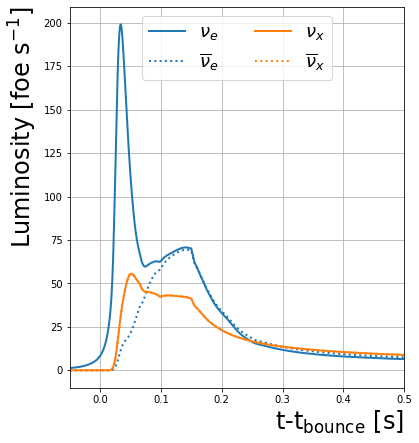

In [4]:
fig, ax = plt.subplots(1, figsize=(6,7))
for flavor in Flavor:

    ax.plot(time, luminosity[flavor]/1e51, # Report Luminosity in units foe/s
            label = flavor.to_tex(),
            color = 'C0' if flavor.is_electron else 'C1',
            ls = '-' if flavor.is_neutrino else ':',
            lw = 2 )

ax.set( xlim=(-0.05, 0.5))
ax.grid()
ax.legend(loc = 'upper center', ncol = 2, fontsize = 18)

ax.set_xlabel(r't-t$_{\rm bounce}$ [s]', fontsize = 24, horizontalalignment = 'right', x = 1 )
ax.set_ylabel(r'Luminosity [foe s$^{-1}$]', fontsize = 24, horizontalalignment = 'right', y = 1 );    